### Instalacion e Importacion de Librerias

In [ ]:
%pip install -r requirements.txt

In [ ]:
!kaggle competitions download -c home-credit-default-risk
!mkdir data
!unzip home-credit-default-risk.zip -d data/
!rm *.zip

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline


### Leer los datos

In [4]:
# Defino mis variables de interes
# (Ver notebook de Analisis Exploratorio de Datos)
INTEREST_VARIABLES = [
    "NAME_INCOME_TYPE",
    "NAME_EDUCATION_TYPE",
    "NAME_FAMILY_STATUS",
    "NAME_HOUSING_TYPE",
    "DAYS_BIRTH",
    "DAYS_EMPLOYED",
    "OCCUPATION_TYPE",
    "ORGANIZATION_TYPE",
    "CODE_GENDER",
    "OWN_CAR_AGE"
]

In [31]:
# Leer los datos
df_train = pd.read_csv("data/application_train.csv")
df_train.shape

(307511, 122)

In [33]:
# Separar los datos en variables y variable objetivo
X = df_train[INTEREST_VARIABLES]
y = df_train.TARGET

In [7]:
X.head()

,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,OCCUPATION_TYPE,ORGANIZATION_TYPE,CODE_GENDER,OWN_CAR_AGE
0,Working,Secondary / secondary special,Single / not married,House / apartment,-9461,-637,Laborers,Business Entity Type 3,M,NaN
1,State servant,Higher education,Married,House / apartment,-16765,-1188,Core staff,School,F,NaN
2,Working,Secondary / secondary special,Single / not married,House / apartment,-19046,-225,Laborers,Government,M,26.0
3,Working,Secondary / secondary special,Civil marriage,House / apartment,-19005,-3039,Laborers,Business Entity Type 3,F,NaN
4,Working,Secondary / secondary special,Single / not married,House / apartment,-19932,-3038,Core staff,Religion,M,NaN


In [15]:
# Ver informacion de los datos ya filtrados
# con las variables de interes
X.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   NAME_INCOME_TYPE     307511 non-null  object 
 1   NAME_EDUCATION_TYPE  307511 non-null  object 
 2   NAME_FAMILY_STATUS   307511 non-null  object 
 3   NAME_HOUSING_TYPE    307511 non-null  object 
 4   DAYS_BIRTH           307511 non-null  int64  
 5   DAYS_EMPLOYED        307511 non-null  int64  
 6   OCCUPATION_TYPE      211120 non-null  object 
 7   ORGANIZATION_TYPE    307511 non-null  object 
 8   CODE_GENDER          307511 non-null  object 
 9   OWN_CAR_AGE          104582 non-null  float64
dtypes: float64(1), int64(2), object(7)
memory usage: 23.5+ MB


In [12]:
# Miramos a que columnas debemos de procesarles
# los datos nulos.
X.isnull().mean().sort_values(ascending=False) * 100

OWN_CAR_AGE            65.990810
OCCUPATION_TYPE        31.345545
NAME_INCOME_TYPE        0.000000
NAME_EDUCATION_TYPE     0.000000
NAME_FAMILY_STATUS      0.000000
NAME_HOUSING_TYPE       0.000000
DAYS_BIRTH              0.000000
DAYS_EMPLOYED           0.000000
ORGANIZATION_TYPE       0.000000
CODE_GENDER             0.000000
dtype: float64

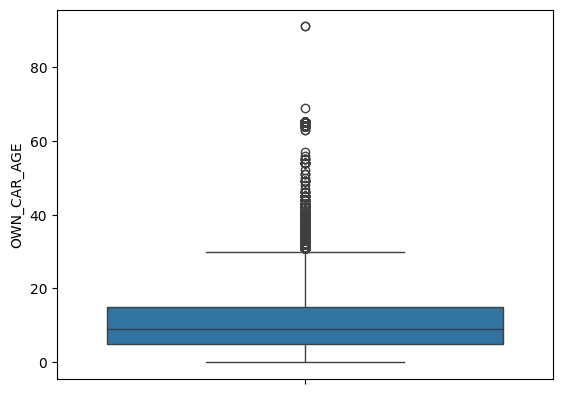

In [23]:
# Boxplot de la variable numerica a la que le faltan datos
sns.boxplot(X["OWN_CAR_AGE"])
plt.show()

In [ ]:
# Conteo de los valores unicos dentro de la
# variable categorica
X["OCCUPATION_TYPE"].value_counts()

OCCUPATION_TYPE
Laborers                 55186
Sales staff              32102
Core staff               27570
Managers                 21371
Drivers                  18603
High skill tech staff    11380
Accountants               9813
Medicine staff            8537
Security staff            6721
Cooking staff             5946
Cleaning staff            4653
Private service staff     2652
Low-skill Laborers        2093
Waiters/barmen staff      1348
Secretaries               1305
Realty agents              751
HR staff                   563
IT staff                   526
Name: count, dtype: int64

- Para el preprocesamiento de la variable categorica vamos a usar el valor "unknown" para su **imputacion**, aunque se podria tambien usar el valor mas frecuente. Pero basandonos en el analisis exploratorio, la primera opcion es la que mas sentido tiene. Tambien, le aplicaremos un One-Hot encoding.

- Para el preprocesamiento de la variable numerica vamos a usar el valor "0" para su **imputacion**, aunque se podria tambien usar el valor de su mediana, ya que al tener tantos outliers (basado en el boxplot) no seria adecuado usar la media.

### Preprocesamiento

In [13]:
from sklearn.impute import SimpleImputer # Para hacer imputacion a variables
from sklearn.preprocessing import OneHotEncoder # Hacer codificacion one-hot (dummies)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [14]:
# Identificar las variables categoricas y numericas
numerical_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]
categorical_cols = [cname for cname in X.columns if X[cname].dtype in ['object']]

In [25]:
# Preprocesamiento para las variables numericas
numerical_transformer = SimpleImputer(strategy="constant", fill_value=0)

# Preprocesamiento para las variables categoricas
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

In [27]:
# Pipeline de procesamiento
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]
)

In [29]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=42)

pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", model)
])

pipe.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant'),
                                                  ['DAYS_BIRTH',
                                                   'DAYS_EMPLOYED',
                                                   'OWN_CAR_AGE']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='unknown',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['NAME_INCOME_TYPE',
                                                   'NAME_EDUCATION_TYPE',
                                                   'NAME_FAMILY_STATUS',
                                                   'NAME_HOUSING_TYPE',
                                                   'OCCUPATION_TYPE',
                                                   'ORGANIZATION_TYPE',
                                                   'CODE_GENDER'])])),
                ('model', RandomForestClassifier(random_state=42))])